# Machine Learning Pipeline

# Research 

## Pipeline I:

In [1]:
################################################
# End-to-End Diabetes Machine Learning Pipeline I
################################################

# 1. Exploratory Data Analysis
# 2. Data Preprocessing & Feature Engineering
# 3. Base Models
# 4. Automated Hyperparameter Optimization
# 5. Stacking & Ensemble Learning
# 6. Prediction for a New Observation
# 7. Pipeline Main Function

In [2]:
import joblib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

## 1. Exploratory Data Analysis

In [3]:
################################################
# 1. Exploratory Data Analysis
################################################

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [4]:
df = pd.read_csv(r"C:\Users\ceren\Desktop\miuul\machine_learning\datasets\diabetes.csv")

check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1

In [5]:
# Değişken türlerinin ayrıştırılması
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)


* Yeni feature ekleyeceğimiz için cat_th=5 oldu.

In [6]:
# Kategorik değişkenlerin incelenmesi
for col in cat_cols:
    cat_summary(df, col)

   Outcome      Ratio
0      500  65.104167
1      268  34.895833
##########################################


* Tek kategorik değişken olan bağımlı değişkenimizin sınıflarının oranı verildi.

In [7]:
# Sayısal değişkenlerin incelenmesi
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


* İnsülin değişkeninde anormallik gözüküyor.

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


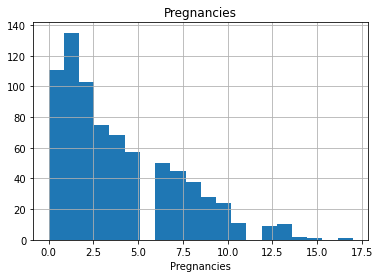

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


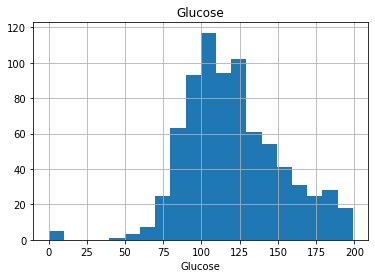

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


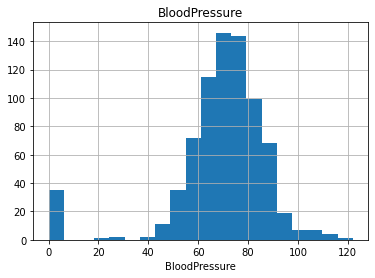

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


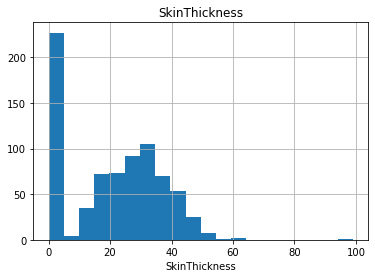

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


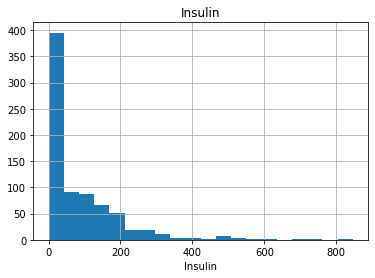

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


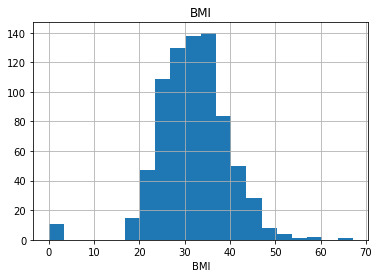

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


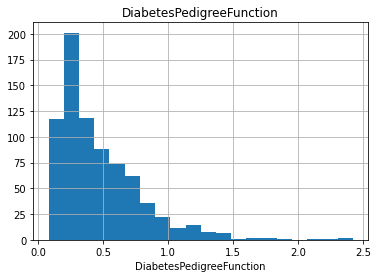

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


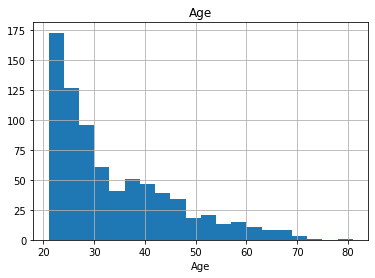

In [8]:
for col in num_cols:
    num_summary(df, col, plot=True)

* Verilen grafiklerde dağılımın dışında 0 değerleri göze çarpıyor, bunun sebebi boş değerlerin 0 olarak girilmesinden kaynaklanıyor.

* Pycharm kullanırken plot içeren kodlara baktıktan sonra # konulmalı.

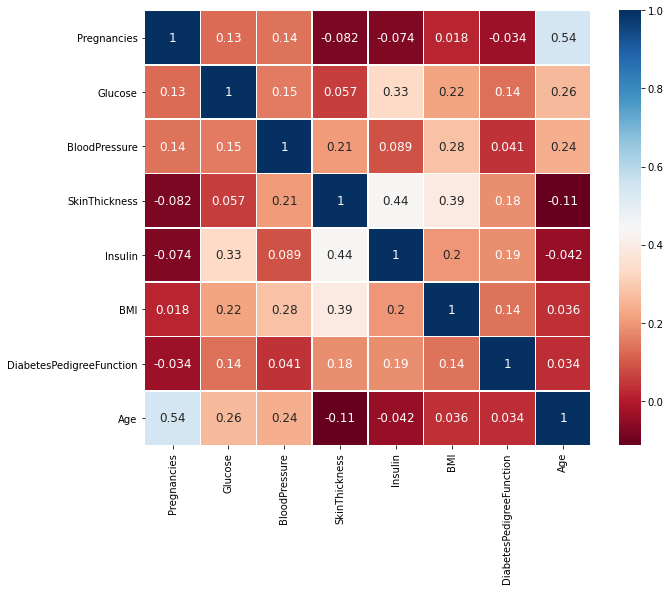

In [9]:
# Sayısal değişkenkerin birbirleri ile korelasyonu
correlation_matrix(df, num_cols)

* Hamilelik ve yaş arasında orta şiddetli korelasyon ilişkisi vardır.

* Cilt kalınlığı ve insülin ile orta-zayıf şiddetli korelasyon ilişkisi vardır.

In [10]:
# Target ile sayısal değişkenlerin incelemesi
for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




## 2. Data Preprocessing & Feature Engineering

In [11]:
################################################
# 2. Data Preprocessing & Feature Engineering
################################################

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe


In [12]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [13]:
# Değişken isimleri büyütmek
df.columns = [col.upper() for col in df.columns]


#### *  Glucose

In [14]:
# Glucose
df['NEW_GLUCOSE_CAT'] = pd.cut(x=df['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

0-139 -> normal

139-200 -> prediabetes

In [15]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes
1,1,85,66,29,0,26.6,0.351,31,0,normal
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes
3,1,89,66,23,94,28.1,0.167,21,0,normal
4,0,137,40,35,168,43.1,2.288,33,1,normal


Şimdilik glikoz değişkenini silmeyeceğiz fakat ağaç yöntemlerine gittiğimizde, çeşitli feature importance yöntemleri kullandığımızda silme kararını alabiliriz.

#### * Age

In [16]:
# Age
df.loc[(df['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
df.loc[(df['AGE'] >= 35) & (df['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
df.loc[(df['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

#### * BMI

In [17]:
# BMI
df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                             labels=["underweight", "healthy", "overweight", "obese"])

In [18]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT,NEW_AGE_CAT,NEW_BMI_RANGE
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes,middleage,obese
1,1,85,66,29,0,26.6,0.351,31,0,normal,young,overweight
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes,young,healthy
3,1,89,66,23,94,28.1,0.167,21,0,normal,young,overweight
4,0,137,40,35,168,43.1,2.288,33,1,normal,young,obese


#### * BloodPressure


In [19]:
# BloodPressure
df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels=["normal", "hs1", "hs2"])


In [20]:
check_df(df) 

##################### Shape #####################
(768, 13)
##################### Types #####################
PREGNANCIES                    int64
GLUCOSE                        int64
BLOODPRESSURE                  int64
SKINTHICKNESS                  int64
INSULIN                        int64
BMI                          float64
DIABETESPEDIGREEFUNCTION     float64
AGE                            int64
OUTCOME                        int64
NEW_GLUCOSE_CAT             category
NEW_AGE_CAT                   object
NEW_BMI_RANGE               category
NEW_BLOODPRESSURE           category
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME NEW_GLUCOSE_CAT NEW_AGE_CAT NEW_BMI_RANGE NEW_BLOODPRESSURE
0            6      148             72             35        0  33.6                     0.627   50        1     prediabetes   middleage         obese            normal
1       

* check df önemli bir fonksiyon. Herhangi bir kod akışından sonra her şeyin yolunda olup olmadığını kontrol ederiz (türettiğimiz yeni değişkenlerden NA değerleri de gelebilirdi, gelmedi)

In [21]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
cat_cols

['NEW_AGE_CAT',
 'OUTCOME',
 'NEW_GLUCOSE_CAT',
 'NEW_BMI_RANGE',
 'NEW_BLOODPRESSURE']

In [22]:
for col in cat_cols:
    cat_summary(df, col)

           NEW_AGE_CAT      Ratio
young              488  63.541667
middleage          230  29.947917
old                 50   6.510417
##########################################
   OUTCOME      Ratio
0      500  65.104167
1      268  34.895833
##########################################
             NEW_GLUCOSE_CAT      Ratio
normal                   571  74.348958
prediabetes              197  25.651042
##########################################
             NEW_BMI_RANGE      Ratio
obese                  472  61.458333
overweight             179  23.307292
healthy                102  13.281250
underweight             15   1.953125
##########################################
        NEW_BLOODPRESSURE      Ratio
normal                563  73.307292
hs1                   145  18.880208
hs2                    60   7.812500
##########################################


* Oluşturduğumuz yeni değişkenlerin bağımlı değişkenle ilişkisi ne şekilde?

In [23]:
for col in cat_cols:
    target_summary_with_cat(df, "OUTCOME", col)


             TARGET_MEAN
NEW_AGE_CAT             
middleage       0.543478
old             0.340000
young           0.258197


         TARGET_MEAN
OUTCOME             
0                  0
1                  1


                 TARGET_MEAN
NEW_GLUCOSE_CAT             
normal              0.232925
prediabetes         0.685279


               TARGET_MEAN
NEW_BMI_RANGE             
underweight       0.133333
healthy           0.068627
overweight        0.223464
obese             0.463983


                   TARGET_MEAN
NEW_BLOODPRESSURE             
normal                0.316163
hs1                   0.420690
hs2                   0.483333




* Kan basıncına bakıldığında kayda değer bir gözlem yok.

* BMI'da sağlıklı sınıfın 1'den ne kadar uzak olduğunu görüyoruz. Obez ise 1'e diğerlerinden yakın.

* BMI'ın sayısal şekilde sınıflara ayrılması da yararlı bir değişiklik olabilir (Ağaç yöntemlerinin mantığında)


In [24]:
cat_cols = [col for col in cat_cols if "OUTCOME" not in col]


* Bağımlı değişkenimizi çıakrdık.

In [25]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [26]:
df.columns = [col.upper() for col in df.columns]


In [27]:
check_df(df)


##################### Shape #####################
(768, 17)
##################### Types #####################
PREGNANCIES                      int64
GLUCOSE                          int64
BLOODPRESSURE                    int64
SKINTHICKNESS                    int64
INSULIN                          int64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                              int64
OUTCOME                          int64
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_BMI_RANGE_HEALTHY            uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object
##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  DIABETESPEDIGREEFUNCTION  AGE  OUTCOME  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PR

In [28]:
# Son güncel değişken türlerimi tutuyorum.
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
cat_cols = [col for col in cat_cols if "OUTCOME" not in col]
cat_cols

['NEW_AGE_CAT_OLD',
 'NEW_AGE_CAT_YOUNG',
 'NEW_GLUCOSE_CAT_PREDIABETES',
 'NEW_BMI_RANGE_HEALTHY',
 'NEW_BMI_RANGE_OVERWEIGHT',
 'NEW_BMI_RANGE_OBESE',
 'NEW_BLOODPRESSURE_HS1',
 'NEW_BLOODPRESSURE_HS2']

In [29]:
for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


* 0.05, 0.95 aldık çünkü iqr yöntemi çok değişkenli etkiyi göz önünde bulunduramaz o halde en uç değerlerin tespitini yapacağız. 

* Yapmayadabilirdik çünkü genelinde ağaç yöntemleri kullansak da doğrusal yöntemler de kullanacağız.

In [30]:
replace_with_thresholds(df, "INSULIN")

#### Standartlaştırma

In [31]:
# Standartlaştırma
X_scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)


In [32]:
check_df(X)

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_BMI_RANGE_HEALTHY            uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object
##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  DIABETESPEDIGREEFUNCTION       AGE  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PREDIABETES  NEW_BMI_RANGE_HEALTHY  NEW

* Problem yok (NA ve değişkenler değişmiş olabilirdi)

#### Yaptığımız her şeyin fonksiyonu

In [33]:
def diabetes_data_prep(dataframe):
    dataframe.columns = [col.upper() for col in dataframe.columns]

    # Glucose
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

    # Age
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

    # BMI
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

    # BloodPressure
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    df.columns = [col.upper() for col in df.columns]

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    replace_with_thresholds(df, "INSULIN")

    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y


In [34]:
df = pd.read_csv(r"C:\Users\ceren\Desktop\miuul\machine_learning\datasets\diabetes.csv")
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0  33.6                     0.627   50        1
1            1       85             66             29        0  26.6                     0.351   31        0
2            8      183             64              0        0  23.3                     0.672   32        1
3            1       89             66             23       94  28.1

In [35]:
X, y = diabetes_data_prep(df)

check_df(X)

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_BMI_RANGE_HEALTY             uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object
##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  DIABETESPEDIGREEFUNCTION       AGE  NEW_AGE_CAT_OLD  NEW_AGE_CAT_YOUNG  NEW_GLUCOSE_CAT_PREDIABETES  NEW_BMI_RANGE_HEALTY  NEW_


#### Base Models

In [36]:
######################################################
# 3. Base Models
######################################################
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')), #warningler için yazdık sağdaki parametreleri
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False)) uzun sürüyor.
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")


In [38]:
base_models(X, y)

Base Models....
roc_auc: 0.8409 (LR) 
roc_auc: 0.791 (KNN) 
roc_auc: 0.8355 (SVC) 
roc_auc: 0.6472 (CART) 
roc_auc: 0.8286 (RF) 
roc_auc: 0.8196 (Adaboost) 
roc_auc: 0.8241 (GBM) 
roc_auc: 0.8015 (XGBoost) 
roc_auc: 0.807 (LightGBM) 


In [37]:
base_models(X, y, scoring="accuracy")


Base Models....
accuracy: 0.7604 (LR) 
accuracy: 0.7617 (KNN) 
accuracy: 0.7656 (SVC) 
accuracy: 0.6849 (CART) 
accuracy: 0.7786 (RF) 
accuracy: 0.7578 (Adaboost) 
accuracy: 0.7539 (GBM) 
accuracy: 0.7448 (XGBoost) 
accuracy: 0.7383 (LightGBM) 


#### Automated Hyperparameter Optimization

In [39]:
######################################################
# 4. Automated Hyperparameter Optimization
######################################################

knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}


classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

In [40]:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"): #cv 5 olabilir
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [41]:
best_models = hyperparameter_optimization(X, y)


Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.791
roc_auc (After): 0.8211
KNN best params: {'n_neighbors': 20}

########## CART ##########
roc_auc (Before): 0.6483
roc_auc (After): 0.7943
CART best params: {'max_depth': 6, 'min_samples_split': 23}

########## RF ##########
roc_auc (Before): 0.8275
roc_auc (After): 0.8354
RF best params: {'max_depth': 15, 'max_features': 5, 'min_samples_split': 15, 'n_estimators': 200}

########## XGBoost ##########
roc_auc (Before): 0.8015
roc_auc (After): 0.8179
XGBoost best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

########## LightGBM ##########
roc_auc (Before): 0.807
roc_auc (After): 0.8185
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 300}



* LightGBM, XGBoost gibi seçilebilir. Aralıkları çok detaylı vermediğimiz için kesin bu başarılı olur diyemiyoruz.

#### Stacking & Ensemble Learning

* Birden fazla modeli bir arada kullanmak işine yarar.

In [48]:
######################################################
# 5. Stacking & Ensemble Learning
######################################################

def voting_classifier(best_models, X, y):
    print("Voting Classifier...")

    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

In [49]:
voting_clf = voting_classifier(best_models, X, y)


Voting Classifier...
Accuracy: 0.76953125
F1Score: 0.6339904648728178
ROC_AUC: 0.8356268630856453


#### Prediction for a New Observation

In [45]:
X.columns

Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN', 'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'NEW_AGE_CAT_OLD', 'NEW_AGE_CAT_YOUNG', 'NEW_GLUCOSE_CAT_PREDIABETES', 'NEW_BMI_RANGE_HEALTY', 'NEW_BMI_RANGE_OVERWEIGHT', 'NEW_BMI_RANGE_OBESE', 'NEW_BLOODPRESSURE_HS1', 'NEW_BLOODPRESSURE_HS2'], dtype='object')

In [46]:
random_user = X.sample(1, random_state=45)
random_user

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_GLUCOSE_CAT_PREDIABETES,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
195,0.342981,1.161295,0.770014,1.283638,1.458025,0.940144,-0.232176,-0.360847,0,1,1,0,0,1,1,0


In [47]:
voting_clf.predict(random_user)

array([1], dtype=int64)

* Modeli kaydedelim;

In [50]:
joblib.dump(voting_clf, "voting_clf2.pkl") #kaydettik dizine


['voting_clf2.pkl']

In [51]:
new_model = joblib.load("voting_clf2.pkl") #kullanalım.
new_model.predict(random_user)

array([1], dtype=int64)

## Pipeline II

In [52]:
################################################
# End-to-End Diabetes Machine Learning Pipeline II
################################################

import joblib
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


In [53]:
################################################
# Helper Functions
################################################
# from helpers import * derdik dışardan oluşturduğumuz dosya ile fonksiyonla çağırsaydık;
# utils.py bu tarzda dosyalar
# helpers.py

# Data Preprocessing & Feature Engineering
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def diabetes_data_prep(dataframe):
    dataframe.columns = [col.upper() for col in dataframe.columns]

    # Glucose
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

    # Age
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

    # BMI
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

    # BloodPressure
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

    replace_with_thresholds(df, "INSULIN")

    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y

# Base Models
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier()),
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

# Hyperparameter Optimization

# config.py bu dosyanın içinde aşağıdakiler olabilir

knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200],
                  "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500],
                   "colsample_bytree": [0.7, 1]}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

# Stacking & Ensemble Learning
def voting_classifier(best_models, X, y):
    print("Voting Classifier...")
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]), ('RF', best_models["RF"]),
                                              ('LightGBM', best_models["LightGBM"])],
                                  voting='soft').fit(X, y)
    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf


In [54]:
################################################
# Pipeline Main Function
################################################

def main():
    df = pd.read_csv(r"C:\Users\ceren\Desktop\miuul\machine_learning\datasets\diabetes.csv") #veriyi çek
    X, y = diabetes_data_prep(df) #veri önişleme
    base_models(X, y) #genel model
    best_models = hyperparameter_optimization(X, y) #hp optimizasyonu
    voting_clf = voting_classifier(best_models, X, y) #voting classifier
    joblib.dump(voting_clf, "voting_clf.pkl") #bir yere kaydet
    return voting_clf

if __name__ == "__main__": #python dosyasını çalıştıracak bölüm
    print("İşlem başladı")
    main()



İşlem başladı
Base Models....
roc_auc: 0.8409 (LR) 
roc_auc: 0.791 (KNN) 
roc_auc: 0.8355 (SVC) 
roc_auc: 0.6583 (CART) 
roc_auc: 0.8261 (RF) 
roc_auc: 0.8196 (Adaboost) 
roc_auc: 0.8238 (GBM) 
roc_auc: 0.8015 (XGBoost) 
roc_auc: 0.807 (LightGBM) 
Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.791
roc_auc (After): 0.8211
KNN best params: {'n_neighbors': 20}

########## CART ##########
roc_auc (Before): 0.6426
roc_auc (After): 0.7943
CART best params: {'max_depth': 6, 'min_samples_split': 23}

########## RF ##########
roc_auc (Before): 0.8214
roc_auc (After): 0.8347
RF best params: {'max_depth': None, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 200}

########## XGBoost ##########
roc_auc (Before): 0.8015
roc_auc (After): 0.8255
XGBoost best params: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

########## LightGBM ##########
roc_auc (Before): 0.807
roc_auc (After): 0.8234
LightGBM best params: {'colsam

In [55]:
# git github entegrasyonu olmalı
# makefile 
# veri tabanlarından
# log
# class
# docker 
# requirement.txt

# Prediction

# Pipeline III

In [57]:
import joblib
import pandas as pd
df = pd.read_csv(r"C:\Users\ceren\Desktop\miuul\machine_learning\datasets\diabetes.csv")


In [58]:
random_user = df.sample(1, random_state=45)

new_model = joblib.load("voting_clf.pkl")

In [59]:
new_model.predict(random_user)

C:\Users\ceren\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Age
- BloodPressure
- DiabetesPedigreeFunction
- Glucose
- Insulin
- ...
Feature names seen at fit time, yet now missing:
- AGE
- BLOODPRESSURE
- DIABETESPEDIGREEFUNCTION
- GLUCOSE
- INSULIN
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 9 features, but KNeighborsClassifier is expecting 16 features as input.

* Verimizi bir çok işleme soktuğumuz yeni değişkenler çıkardığımız için yeni gelen veriler ile eşleşmedi. Yeni veriyi eski veriye dönüştürmemiz gerekiyor.

In [ ]:
# from diabetes_pipeline import diabetes_data_prep yerine;

In [61]:
# Data Preprocessing & Feature Engineering
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def diabetes_data_prep(dataframe):
    dataframe.columns = [col.upper() for col in dataframe.columns]

    # Glucose
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

    # Age
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

    # BMI
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

    # BloodPressure
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

    cat_cols, num_cols, cat_but_car = grab_col_names(dataframe, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if "OUTCOME" not in col]

    df = one_hot_encoder(dataframe, cat_cols, drop_first=True)

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

    replace_with_thresholds(df, "INSULIN")

    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y

Bu kısım scoring olarak da karşımıza çıkabilir.

In [62]:
X, y = diabetes_data_prep(df)

In [64]:
random_user = X.sample(1, random_state=50)
random_user

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_AGE_CAT_old,NEW_AGE_CAT_young,NEW_GLUCOSE_CAT_prediabetes,NEW_BMI_RANGE_healty,NEW_BMI_RANGE_overweight,NEW_BMI_RANGE_obese,NEW_BLOODPRESSURE_hs1,NEW_BLOODPRESSURE_hs2
575,-0.844885,-0.059293,-1.297896,1.660007,-0.113914,0.445159,-0.579489,-0.701198,0,1,0,0,0,1,0,0


In [65]:
new_model = joblib.load("voting_clf.pkl")

new_model.predict(random_user)


array([0], dtype=int64)